In [1]:
import os
import time
import pandas as pd
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import signal

In [2]:
        
def extract(path,SENSORS=True,WIFI=True,POSI=True):
    # SENSORS dictionary
    if SENSORS:
        sensors = {
            'MAGN':{'indexs':[0,1,2],'names':['Mag_X(uT)','Mag_Y(uT)','Mag_Z(uT)']},
           'ACCE':{'indexs':[0,1,2],'names':['Acc_X(m/s^2)','Acc_Y(m/s^2)','Acc_Z(m/s^2)']},
           'GYRO':{'indexs':[0,1,2],'names':['Gyr_X(rad/s)','Gyr_Y(rad/s)','Gyr_Z(rad/s)']},
           'PRES':{'indexs':[0],'names':['Pres(mbar)']},
           'LIGHT':{'indexs':[0],'names':['Light(lux)']},
           'TEMP':{'indexs':[0],'names':['temp(ºC)']},
           'HUMI':{'indexs':[0],'names':['humi(%)']},
           'AHRS':{'indexs':[0,1,2,3,4,5],'names':['PitchX(º)','RollY(º)','YawZ(º)','RotVecX()','RotVecY()','RotVecZ()']} }

        # sensor data intialization
        sensor_dic = {
            'MAGN':{'time':[]},
           'ACCE':{'time':[]},
           'GYRO':{'time':[]},
           'PRES':{'time':[]},
           'LIGHT':{'time':[]},
           'TEMP':{'time':[]},
           'HUMI':{'time':[]},
           'AHRS':{'time':[]},
                  }
    # WIFI dictionary
    if WIFI:
        wifi_dic = {
            'time':[],
            'Name_SSID':[],
            'MAC_BSSID;':[],
            'Frequency(Hz)':[],
            'RSS(dBm)':[],  
        }

    # POSI dictionary
    if POSI:
        posi_dic = {'time':[],
                    'Latitude':[],
                    'Longitude':[],
                    'floor ID':[],
                    'Building ID':[]}
        
    with open(path,mode='r') as f:
        time_offsets = {}
        counter = 0 
        for line in f:
            counter+=1
            ### controller
#                 if counter>3000:
#                     break
            ### controller
            words=line.split(";")
            sensor_type = words[0]
            
            
            if SENSORS and sensor_type in sensors:
                # extract sensor data
                app_time = float(words[1])
                sensor_time = float(words[2])
                sensor_data = words[3:]

                # adjust app time using sensor time
                time_offset = time_offsets.setdefault(sensor_type,app_time-sensor_time)
                time_adjusted = np.around(sensor_time+time_offset,2)
                # printer
                counter += 1
                #print(sensor_type+' counter:'+ str(counter)+ ' '+str(time_adjusted),end='\r')

                # form data frame
                sensor_dic[sensor_type]['time'].append(time_adjusted) 
                for index,name in zip(sensors[sensor_type]['indexs'],sensors[sensor_type]['names']):
                    if name not in sensor_dic[sensor_type]:
                        sensor_dic[sensor_type][name] = []
                    sensor_dic[sensor_type][name].append(float(sensor_data[index]))
            elif WIFI and sensor_type == 'WIFI':
                # extract sensor data
                app_time = float(words[1])
                sensor_time = float(words[2])
                # adjust app time using sensor time
                time_offset = time_offsets.setdefault(sensor_type,app_time-sensor_time)
                time_adjusted = np.around(sensor_time+time_offset,2)
                names = list(wifi_dic.keys())
                wifi_dic[names[0]].append(time_adjusted) # time
                wifi_dic[names[1]].append(words[3]) # Name_SSID
                wifi_dic[names[2]].append(words[4]) # MAC_BSSID
                wifi_dic[names[3]].append(int(words[5])) # Frequency(Hz)
                wifi_dic[names[4]].append(int(words[6])) # RSS(dBm)
            elif POSI and sensor_type == 'POSI':
                names = list(posi_dic.keys())
                posi_dic[names[0]].append(float(words[1])) # time
                posi_dic[names[1]].append(float(words[3])) # Latitude
                posi_dic[names[2]].append(float(words[4])) # Longitude
                posi_dic[names[3]].append(int(words[5])) # floor ID
                posi_dic[names[4]].append(int(words[6])) # Building ID\
            else:
                pass
  
        
    res = []
    # process sensors dataframe
    if(SENSORS):
        sensors_df=pd.DataFrame()                   
        for sensor_type,data in sensor_dic.items():
            df = pd.DataFrame(data)
            df.drop_duplicates('time',keep='last',inplace=True)
            df.set_index('time',drop=True,inplace=True)
            sensors_df = sensors_df.join(df,how='outer')
        res.append(sensors_df)
    # process WIFI dataframe
    if(WIFI):
        wifi_df = pd.DataFrame(wifi_dic)
        mac_list = wifi_df[list(wifi_dic.keys())[2]].unique() # get MAC list
        dummies = pd.get_dummies(wifi_df[list(wifi_dic.keys())[2]],prefix='',prefix_sep='') # get MAC dummies
        wifi_res = pd.DataFrame()

        for mac in mac_list:
            mac_df = pd.DataFrame()
            mac_df['time'] = wifi_df[dummies[mac]==1]['time'].values
            mac_df[mac] = wifi_df[dummies[mac]==1][list(wifi_dic.keys())[4]].values # RSSI values
            mac_df.set_index('time',drop=True,inplace=True)
            wifi_res = wifi_res.join(mac_df,how='outer')
        wifi_res[wifi_res.columns].astype(np.float16) # memory control: SSID values
        res.append(wifi_res) # add WIFI dataframe to result
    # process real trace dataframe
    if(POSI):
        posi_res = pd.DataFrame(posi_dic)
        posi_res.set_index('time',drop=True,inplace=True) 
        posi_res[list(posi_dic.keys())[3]] = posi_res[list(posi_dic.keys())[3]].astype(np.int8) # memory control: floor ID
        posi_res[list(posi_dic.keys())[4]] = posi_res[list(posi_dic.keys())[4]].astype(np.int16) # memory control: building ID
        res.append(posi_res) # add POSI dataframe to result
    return res

In [3]:
def load_train(folder):
    sensors_df = pd.DataFrame()
    wifi_df = pd.DataFrame()
    posi_df = pd.DataFrame()
    tm_func = time.time()
    for root,_,files in os.walk(folder):
        for file_name in files:
            # path
            path = os.path.join(root,file_name)
            # trace number & trail number
            split = file_name[1:].strip('.txt').split('_')
            trace_num = np.int16(split[0])
            trail_num = np.int8(split[1])
            # extraction
            tm_st = time.time() # record start time
            sensors_df_sub,wifi_df_sub,posi_df_sub = extract(path,WIFI=True,POSI=True)
            sensors_df_sub['trace'] = trace_num
            sensors_df_sub['trail'] = trail_num
            wifi_df_sub['trace'] = trace_num
            wifi_df_sub['trail'] = trail_num
            posi_df_sub['trace'] = trace_num
            posi_df_sub['trail'] = trail_num
            sensors_df = sensors_df.append(sensors_df_sub)
            wifi_df = wifi_df.append(wifi_df_sub)
            posi_df = posi_df.append(posi_df_sub)
            tm_end = time.time() # record end time
            print('Trace:',trace_num,' trail:',trail_num,' current cost time(s):','%.2f'%(tm_end-tm_st),' total cost time(s):','%.2f'%(tm_end-tm_func))
    print('Done!')
    return sensors_df,wifi_df,posi_df

def load_valid(folder):
    sensors_df = pd.DataFrame()
    wifi_df = pd.DataFrame()
    posi_df = pd.DataFrame()
    tm_func = time.time()
    for root,_,files in os.walk(folder):
        for file_name in files:
            # path
            path = os.path.join(root,file_name)
            # trace number & trail number
            split = file_name[1:].strip('.txt').split('_')
            trace_num = np.int16(split[0])
            # extraction
            tm_st = time.time() # record start time
            sensors_df_sub,wifi_df_sub,posi_df_sub = extract(path,WIFI=True,POSI=True)
            sensors_df_sub['trace'] = trace_num
            wifi_df_sub['trace'] = trace_num
            posi_df_sub['trace'] = trace_num
            sensors_df = sensors_df.append(sensors_df_sub)
            wifi_df = wifi_df.append(wifi_df_sub)
            posi_df = posi_df.append(posi_df_sub)
            tm_end = time.time() # record end time
            print('Trace:',trace_num,' current cost time(s):','%.2f'%(tm_end-tm_st),' total cost time(s):','%.2f'%(tm_end-tm_func))
    print('Done!')
    return sensors_df,wifi_df,posi_df

In [4]:
train_sensors,train_wifi,train_posi = load_train('../data/2020/Logfiles/01-Training/')

Trace: 1  trail: 1  current cost time(s): 2.70  total cost time(s): 2.70
Trace: 1  trail: 2  current cost time(s): 2.79  total cost time(s): 5.50
Trace: 1  trail: 3  current cost time(s): 2.84  total cost time(s): 8.34
Trace: 1  trail: 4  current cost time(s): 2.78  total cost time(s): 11.11
Trace: 2  trail: 1  current cost time(s): 1.56  total cost time(s): 12.67
Trace: 2  trail: 2  current cost time(s): 1.62  total cost time(s): 14.29
Trace: 2  trail: 3  current cost time(s): 1.61  total cost time(s): 15.90
Trace: 2  trail: 4  current cost time(s): 1.61  total cost time(s): 17.52
Trace: 3  trail: 1  current cost time(s): 1.47  total cost time(s): 18.99
Trace: 3  trail: 2  current cost time(s): 1.41  total cost time(s): 20.40
Trace: 3  trail: 3  current cost time(s): 1.50  total cost time(s): 21.91
Trace: 3  trail: 4  current cost time(s): 1.44  total cost time(s): 23.35
Trace: 4  trail: 1  current cost time(s): 1.43  total cost time(s): 24.78
Trace: 4  trail: 2  current cost time(s):

In [5]:
valid_sensors,valid_wifi,valid_posi = load_valid('../data/2020/Logfiles/02-Validation/')

Trace: 1  current cost time(s): 2.68  total cost time(s): 2.69
Trace: 2  current cost time(s): 2.68  total cost time(s): 5.36
Trace: 3  current cost time(s): 4.02  total cost time(s): 9.38
Trace: 4  current cost time(s): 3.43  total cost time(s): 12.81
Trace: 5  current cost time(s): 3.19  total cost time(s): 16.01
Trace: 6  current cost time(s): 2.66  total cost time(s): 18.66
Trace: 7  current cost time(s): 1.86  total cost time(s): 20.53
Trace: 8  current cost time(s): 1.65  total cost time(s): 22.18
Trace: 9  current cost time(s): 2.22  total cost time(s): 24.40
Trace: 10  current cost time(s): 2.32  total cost time(s): 26.72
Trace: 11  current cost time(s): 3.34  total cost time(s): 30.06
Trace: 12  current cost time(s): 5.90  total cost time(s): 35.95
Trace: 13  current cost time(s): 6.22  total cost time(s): 42.17
Done!


In [6]:
# SENSORS DATAFRAME preprocess
frequency = 50
def sensors_resample(sensor_df,frequency=frequency):
    identity_cols = ['trace','trail']
    id_cols = []
    for col in sensor_df.columns:
        if col in identity_cols:
            id_cols.append(col)
    # resample
    period = 1/50 #s
    period = period * 1000 # ms
    period = str(period)+'ms'
    # resample and fill NAN
    sensor_df.index = pd.to_timedelta(sensor_df.index,'s')
    sensor_df = sensor_df.groupby(id_cols).resample(period).last().fillna(method='bfill',axis=0).fillna(method='ffill',axis=0)
    for i in range(len(id_cols)):
        sensor_df.index = sensor_df.index.droplevel()
    sensor_df.index = np.float64(sensor_df.index)/1e+9
    return sensor_df

train_sensors = sensors_resample(train_sensors)
valid_sensors = sensors_resample(valid_sensors)

In [7]:
# WIFI DATAFRAME preprocess
class wifi_preprocessor:
    def reorder_cols(self,df,exception=['trace,trail']):
        cols = df.columns
        exception_real = []
        for item in exception:
            if item in cols:
                exception_real.append(item)
                cols.remove(item)
        cols = sorted(cols)
        cols.extend(exception_real)
        return cols
    
    def __init__(self,train_wifi):
        train_wifi = train_wifi.reindex(self.reorder_cols(train_wifi), axis=1)
        self.train_macs = [col for col in train_wifi.columns]
        self.train_macs.remove('trace')
        self.train_macs.remove('trail')

    def align_cols(self,valid_wifi):
        
        
        valid_wifi = valid_wifi.reindex(self.reorder_cols(valid_wifi), axis=1)
        valid_macs = [col for col in valid_wifi.columns]
        #valid_macs.remove('trace')
        
        except_cols = ['trace','trail']
        for exct_col in except_cols:
            if exct_col in valid_macs:
                valid_macs.remove(exct_col)
        
        
        # enrich validation with macs in training
        for col in self.train_macs:
            if col not in valid_macs:
                valid_wifi[col] = np.float64(-100)
                
        # delete validation macs not in training
        valid_macs = [col for col in valid_wifi.columns]
        for exct_col in except_cols:
            if exct_col in valid_macs:
                valid_macs.remove(exct_col)      
        valid_macs = sorted(valid_macs)
        cols_delete = []
        for col in valid_macs:
            if col not in self.train_macs:
                cols_delete.append(col)
        valid_wifi = valid_wifi.drop(labels=cols_delete,axis=1)
        # reorder features and fillna
        valid_wifi = valid_wifi.reindex(self.reorder_cols(valid_wifi), axis=1).fillna(-100)
        return valid_wifi
    
wifi_df_converter = wifi_preprocessor(train_wifi)
valid_wifi = wifi_df_converter.align_cols(valid_wifi)
train_wifi = wifi_df_converter.align_cols(train_wifi)

In [8]:
# POSITION DATAFRAME preprocess
class posi_preprocessor:
    def __init__(self,train_posi):
        self.ref_latitude,self.ref_longitude = train_posi.iloc[0]['Latitude'],train_posi.iloc[0]['Longitude']
    def add_projected_cols(self,valid_posi):
        valid_posi['x'],valid_posi['y'] = self.geo_convert(self.ref_latitude,
                                              self.ref_longitude,
                                              valid_posi['Latitude'],
                                              valid_posi['Longitude'])
        return valid_posi
    
    def geo_convert(self,init_latitude,init_longitude,Lats,Lngs):
        proj = pyproj.Proj(proj='tmerc',lat_0 = init_longitude,lon_0 = init_latitude,preserve_units=False)
        xs = []
        ys = []
        for lat,lng in zip(Lats,Lngs):
            x,y = proj(lat,lng) 
            xs.append(x)
            ys.append(y)
        return np.array(xs,dtype = np.float16).round(2),np.array(ys,dtype = np.float16).round(2)
    
    def get_reference():
        return self.ref_latitude,self.ref_longitude
    
posi_df_converter = posi_preprocessor(train_posi)
train_posi = posi_df_converter.add_projected_cols(train_posi)
valid_posi = posi_df_converter.add_projected_cols(valid_posi)

# Plot

In [9]:
def plot_traces(posi_df,columns=['x','y','floor ID']):
    '''
    plot each floor
    '''
    ax=plt.axes(projection='3d')
    for floor in range(5):
        floor = floor+1
        floor_df = posi_df[posi_df[columns[2]]==floor]
        ax.plot3D(floor_df[columns[0]].values,floor_df[columns[1]].values,floor)
def plot_traces2(x,y,f):
    '''
    plot each floor
    '''
    ax=plt.axes(projection='3d')
    for floor in range(5):
        floor = floor+1
        indexs = f==floor
        ax.plot3D(x[indexs],y[indexs],f[indexs])
#     ax.view_init(elev=20,    # 仰角
#                  azim=30    # 方位角
#     )
def plot_trace3(traces,predict_x,predict_y,predict_f,real_x,real_y,real_f,plot=False,mask=0):
    '''
    plot each trace
    show both predicted and real traces
    '''
    ax=plt.axes(projection='3d')
    if mask == 0:
        mask = np.unique(traces)
    elif type(mask)!=list:
        mask = [mask]
 
    for tr in np.array(mask):
        indexs = traces==tr
        # plot predicted trace
        ax.scatter(predict_x[indexs],predict_y[indexs],predict_f[indexs])
        if plot:
            ax.plot(predict_x[indexs],predict_y[indexs],predict_f[indexs])
        # scatter real point
        ax.scatter(real_x[indexs],real_y[indexs],real_f[indexs],c='r')
        # show distance between predicted trace and real position
        for px,py,pf,rx,ry,rf in zip(predict_x[indexs],predict_y[indexs],predict_f[indexs],real_x[indexs],real_y[indexs],real_f[indexs]):
            x = [px,rx]
            y = [py,ry]
            f = [pf,rf]
            ax.plot3D(x,y,f,c='r',linestyle='--')
            
def plot_traces4(x,y,f,traces,mask=0):
    '''
    plot each trace
    '''
    ax=plt.axes(projection='3d')
    if mask == 0:
        mask = np.unique(traces)
    elif type(mask)!=list:
        mask = [mask]
    for tr in mask:
        indexs = traces==tr
        ax.plot3D(x[indexs],y[indexs],f[indexs])
        
    xx = np.linspace(-30, 0, 30)
    yy = np.linspace(-30, 30, 60)
    XX, YY = np.meshgrid(xx, yy)
    alpha = 0.2
    ax.plot_surface(XX,YY,Z=XX*0+1,color='b',alpha=alpha)
    ax.plot_surface(XX,YY,Z=XX*0+2,color='g',alpha=alpha) 
    ax.plot_surface(XX,YY,Z=XX*0+3,color='r',alpha=alpha) 
    ax.plot_surface(XX,YY,Z=XX*0+4,color='y',alpha=alpha) 
    ax.plot_surface(XX,YY,Z=XX*0+5,color='w',alpha=alpha) 
    ax.view_init(elev=13,azim=-70 )
    ax.set(xlabel='X',
       ylabel='Y',
       zlabel='Z',

#        xticks=np.arange(0, 10, 2),
#        yticks=np.arange(0, 10, 1),
#        zticks=np.arange(0, 10, 1)
      )


# Prediction

In [10]:
def make_data_train(wifi_df,posi_df,threshold=1):
    # traces trails list initiation
    traces = []
    trails = []
    # get training couples
    data = pd.DataFrame()
    for time,row in posi_df.iterrows():
        # get the attribute of POSI
        trace_num = row['trace']
        trail_num = row['trail']
        lat = row['Latitude']
        lng = row['Longitude']
        x = np.float16(row['x']) 
        y = np.float16(row['y']) 
        f = np.int8(row['floor ID'])
        # search WIFI RSSI near specific POSI
        df_tmp = wifi_df[(np.abs(wifi_df.index-time)<threshold) &(wifi_df['trace']==trace_num) & (wifi_df['trail']==trail_num)].copy()
        df_tmp['Latitude'] = lat
        df_tmp['Longitude'] = lng
        df_tmp['x'] = x
        df_tmp['y'] = y
        df_tmp['floor'] = f
        data = pd.concat([data,df_tmp],axis=0)
        # record the numbers of trace and trails
        traces.extend([trace_num]*len(df_tmp))
        trails.extend([trail_num]*len(df_tmp))
    cols = list(data.columns)
    cols.remove('trace')
    cols.remove('trail')
    feature = data[cols[:-5]].values 
    target_x = data['x'].values
    target_y = data['y'].values
    target_f = data['floor'].values
    return feature,target_x,target_y,target_f,traces,trails

def make_data_valid(wifi_df,posi_df,threshold=1):
    # posi index
    index = 1
    indexs = []
    # posi without wifi counter
    uncovered = 0
    # traces list initiation
    traces = []
    # get training couples
    data = pd.DataFrame()
    for time,row in posi_df.iterrows():
        # get the attribute of POSI
        trace_num = row['trace']
        #trail_num = row['trail']
        lat = row['Latitude']
        lng = row['Longitude']
        x = np.float16(row['x']) 
        y = np.float16(row['y']) 
        f = np.int8(row['floor ID'])
        # search WIFI RSSI near specific POSI
        #df_tmp = wifi_df[(np.abs(wifi_df.index-time)<1) &(wifi_df['trace']==trace_num) & (wifi_df['trail']==trail_num)].copy()
        df_tmp = wifi_df[(np.abs(wifi_df.index-time)<threshold) &(wifi_df['trace']==trace_num)].copy()
        if len(df_tmp)==0:
            uncovered+=1
            continue
        # save posi index
        indexs.extend([index]*len(df_tmp))
        index+=1
        df_tmp['Latitude'] = lat
        df_tmp['Longitude'] = lng
        df_tmp['x'] = x
        df_tmp['y'] = y
        df_tmp['floor'] = f
        data = pd.concat([data,df_tmp],axis=0)
        traces.extend([trace_num]*len(df_tmp))
    cols = list(data.columns)
    cols.remove('trace')
    feature = data[cols[:-5]].values 
    target_x = data['x'].values
    target_y = data['y'].values
    target_f = data['floor'].values
    if uncovered!=0:
        print(uncovered,'positions have no wifi records.')
    return feature,target_x,target_y,target_f,traces,indexs

## floor prediction

In [11]:
train_feature,train_x,train_y,train_floor,train_traces,train_trails = make_data_train(train_sensors,train_posi,threshold=1)
valid_feature,valid_x,valid_y,valid_floor,valid_traces,valid_indexs = make_data_valid(valid_sensors,valid_posi,threshold=1)

In [12]:
idx = list(train_sensors.columns).index('Pres(mbar)')
train_pres = train_feature[:,idx].reshape(-1,1)
idx = list(valid_sensors.columns).index('Pres(mbar)')
valid_pres = valid_feature[:,idx].reshape(-1,1)

from sklearn.ensemble import RandomForestClassifier
rm_cls_f = RandomForestClassifier()
rm_cls_f.fit(train_pres.reshape((-1,1)),train_floor)

rm_cls_f.score(valid_pres.reshape((-1,1)),valid_floor)

0.0

In [13]:
train_feature,train_x,train_y,train_floor,train_traces,train_trails = make_data_train(train_wifi,train_posi,threshold=1)
valid_feature,valid_x,valid_y,valid_floor,valid_traces,valid_indexs = make_data_valid(valid_wifi,valid_posi,threshold=2.17)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
rm_cls_f = RandomForestClassifier()
rm_cls_f.fit(train_feature,train_floor)
rm_cls_f.score(valid_feature,valid_floor)

0.9612403100775194

In [15]:
from sklearn.metrics import accuracy_score
def floor_test(model,valid_wifi,valid_posi,threshold=2.17,correct=True):
    cols = list(valid_wifi.columns)
    cols.remove('trace')
    if 'trail' in cols:
        cols.remove('trail')
    # predict floor
    feature = valid_wifi[cols].values
    floor_predicted = model.predict(feature)
    # correct result
    if correct:
        for index,val in enumerate(floor_predicted):
            if (index==0) or (index==len(floor_predicted-1)):
                continue
            window = floor_predicted[index-1:index+2]
            # calculate the frequency of val
            bincnt = np.bincount(window)
            mode = np.argmax(bincnt)
            # if frquency of mode>1, correct current val to mode
            if bincnt[mode]!=1:
                floor_predicted[index] = mode
    # model accuracy
    wifi_time = valid_wifi.index
    wifi_trace = valid_wifi['trace']
    # get the predicted positions whose time indexs are near the validation time indexs
    floor_predicted_selected = []
    floor_validation_selected = []
    for posi_id,posi_trace in zip(valid_posi.index,valid_posi['trace']):
        tmp = (floor_predicted[(np.abs(wifi_time-posi_id)<2.17)& (wifi_trace==posi_trace)]) # only get the latest position point in the 
        if len(tmp)==0:
            print('no wifi signal acquired in the time window, should increase the threshold.')
        else:
            floor_predicted_selected.append(tmp[-1])
            floor_validation_selected.append(valid_posi.loc[posi_id]['floor ID'])
    print(accuracy_score(floor_predicted_selected,floor_validation_selected))

floor_test(rm_cls_f,valid_wifi,valid_posi,correct=False)

0.9553571428571429


# Pressure analysis

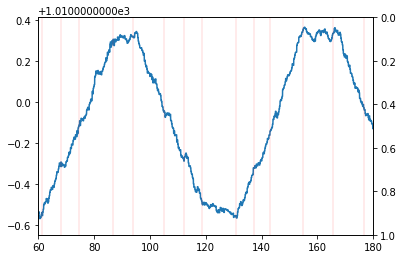

In [16]:
fig,ax1 = plt.subplots()
train_sensors[(train_sensors['trace']==52) & (train_sensors['trail']==1)]['Pres(mbar)'].plot(ax=ax1,xlim=(60,180))
for t in train_posi[(train_posi['trace']==52) & (train_posi['trail']==1)].index:
    plt.axvline(t,c='r',alpha=0.1)
ax2 = ax1.twinx()
ax2.invert_yaxis()
#train_posi[(train_posi['trace']==52) & (train_posi['trail']==1)]['floor ID'].plot(ax=ax2,xlim=(60,180),c='r',style='.',grid='y')

In [17]:
def find_avg(pres,posi_df):
    pres_table = {1:[],2:[],3:[],4:[],5:[]}
    for time in list(posi_df.index):
        f = posi_df.loc[time]['floor ID']
        m = pres.loc[time-0.5:time+0.5].median()
        pres_table[f].append(m)
    for k,v in pres_table.items():
        if len(v)!=0:
            pres_table[k] = np.mean(v)
    return pres_table

dic1 = find_avg(train_sensors[(train_sensors['trace']==52) & (train_sensors['trail']==1)]['Pres(mbar)'],train_posi[(train_posi['trace']==52) & (train_posi['trail']==1 )])
dic1

{1: [],
 2: 1010.3245999999999,
 3: 1009.91335,
 4: 1009.71375,
 5: 1009.4946749999999}

# PDR

In [18]:
from scipy import signal

In [19]:
def lowpass(data,frequency=50,cut_off=15,order=5):
    sig = data.copy()
    b, a = signal.butter(order, cut_off/frequency, 'lowpass')   
    sig = signal.filtfilt(b, a, sig)
    return sig

def smooth(data,p=0.99):
    sig = data.copy()
    for i,val in enumerate(sig):
        if i==0:
            continue
        sig[i] = p*sig[i-1] + (1-p)*sig[i]
    return sig

trace = 5
trail = 1
start = 0
end = 250
t = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)].loc[start:end].index

## calibration and turning detection

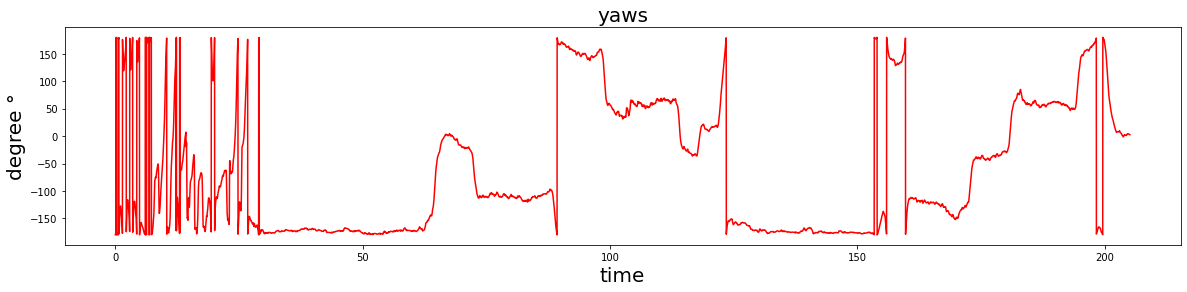

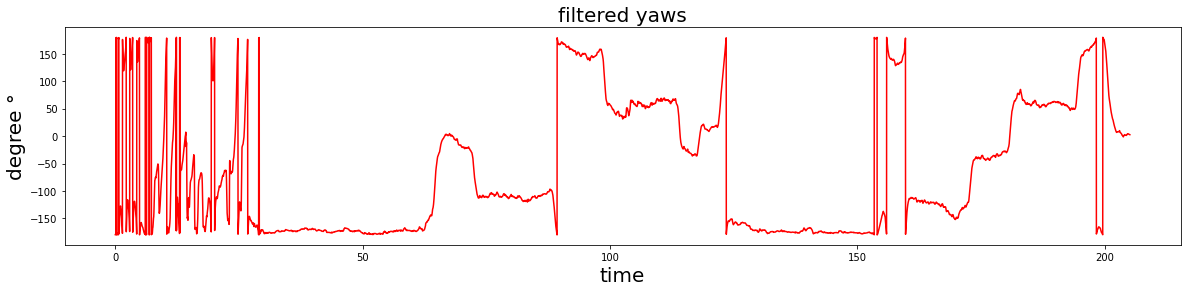

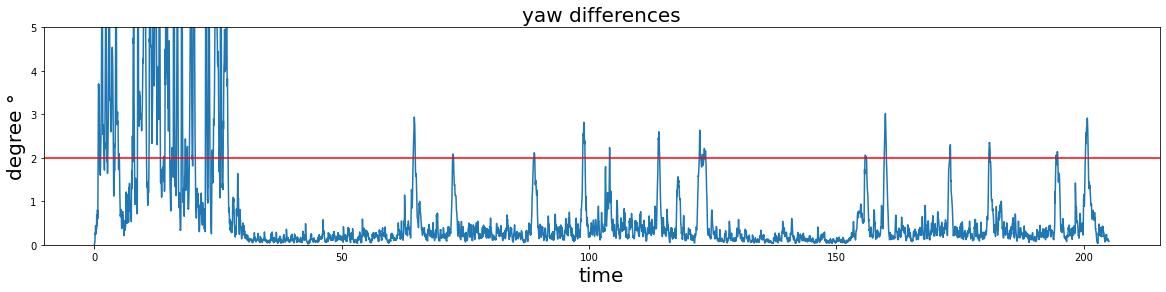

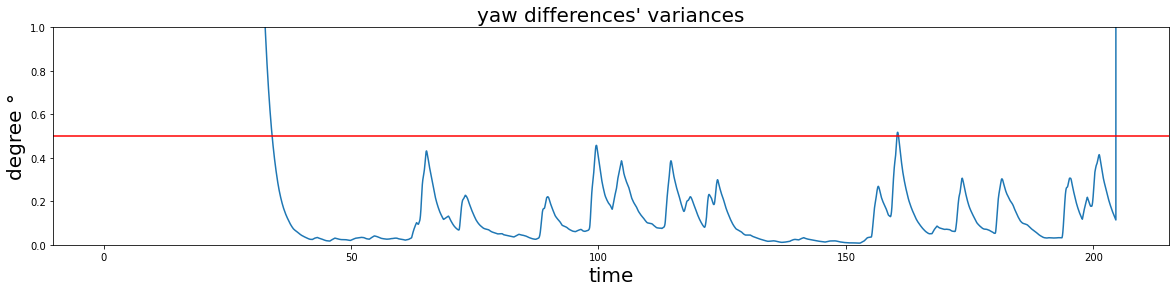

In [100]:
def dif_yaws(yaws):
    v = yaws.copy()
    yaws_dif = []
    for i in range(len(v)):
        if i == 0:
            yaws_dif.append(0)
        else:
            yaws_dif.append(np.min([np.abs(v[i]-v[i-1]),np.abs(360+v[i]-v[i-1]),np.abs(v[i]-v[i-1]-360)]))
    return np.array(yaws_dif)

def var(sig,dw=25,padding=1000):
    v = sig.copy()
    var_dif = []
    for i in range(len(v)):
        if i<dw or i>len(t)-dw-1:
            var_dif.append(padding)
        else:
            var_dif.append(np.var(v[i-dw:i+dw]))
    return np.array(var_dif)
    
yaws = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['YawZ(º)'].loc[start:end].values
yaws_smooth = smooth(yaws,p=0.)    
    
yaws_dif = dif_yaws(yaws)
yaws_dif_var = var(yaws_dif)
yaws_dif_var_smooth = smooth(yaws_dif_var,p=0.99)


var_th = 0.5# threshold of the yaws variance, larger variance indicates calibrating or turning, not walking
dif_th = 2
spinning = (yaws_dif_var_smooth>var_th) | (smooth(yaws_dif,p=0.8)>dif_th)

plt.figure(figsize=(20,4))
#plt.plot(t,yaws,alpha=0.5)
plt.plot(t,yaws,c='r')
plt.title('yaws',fontsize=20)
plt.xlabel('time',fontsize=20)
plt.ylabel('degree °',fontsize=20)

plt.figure(figsize=(20,4))
#plt.plot(t,yaws,alpha=0.5)
plt.plot(t,yaws_smooth,c='r')
plt.title('filtered yaws',fontsize=20)
plt.xlabel('time',fontsize=20)
plt.ylabel('degree °',fontsize=20)


plt.figure(figsize=(20,4))
plt.plot(t,smooth(yaws_dif,p=0.8))
plt.axhline(dif_th,c='r')
plt.ylim(0,5)
plt.title('yaw differences',fontsize=20)
plt.xlabel('time',fontsize=20)
plt.ylabel('degree °',fontsize=20)

plt.figure(figsize=(20,4))
plt.plot(t,yaws_dif_var_smooth)
plt.ylim(0,1)
plt.title('yaw differences\' variances',fontsize=20)
plt.xlabel('time',fontsize=20)
plt.ylabel('degree °',fontsize=20)
plt.axhline(var_th,c='r')

# plt.axvline(93.137,c='r')
# plt.axvline(95.866,c='r')



## step detection

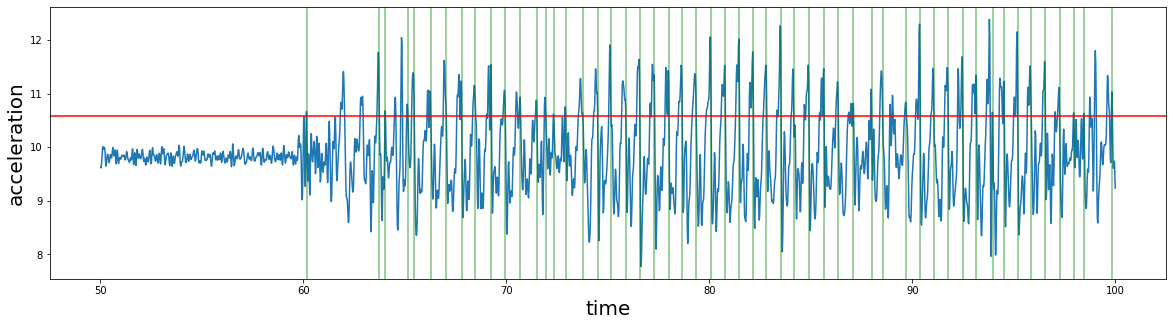

In [106]:
acc_x = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['Acc_X(m/s^2)'].loc[start:end].values
acc_y = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['Acc_Y(m/s^2)'].loc[start:end].values
acc_z = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['Acc_Z(m/s^2)'].loc[start:end].values
acc_all = np.sqrt(acc_x**2+acc_y**2+acc_z**2)
acc_all = lowpass(acc_all,cut_off=20)
#acc_all = smooth(acc_all,p=0.95)
acc_zero = np.mean(acc_all[~spinning])
acc_th = acc_zero + 0.7 # acc thereshold to detect peak



def find_valid_peakT(time,acc_all,acc_th,step_min_frequency=1.3,step_max_frequency=5):
    step_t = []
    for t,v in zip(time,acc_all):
        if v>acc_th:
            step_t.append(t)
    #print(len(step_t))        
    step_max_interval = 1/step_min_frequency
    step_min_interval = 1/step_max_frequency
    # delete peaks that are too close
    delete_id = []
    for i,t in enumerate(step_t):
        if i==0:
            continue
        elif (step_t[i]-step_t[i-1])<step_min_interval:
            delete_id.append(i-1)
    step_t = np.delete(step_t,delete_id)
    #print(len(step_t))
    # delete isolated peaks
    delete_id = []
    for i,t in enumerate(step_t):
        if i==0 or i==len(step_t)-1:
            continue
        elif (step_t[i]-step_t[i-1]>step_max_interval) and (step_t[i+1]-step_t[i]>step_max_interval):
            delete_id.append(i)
    step_t = np.delete(step_t,delete_id)
    #print(len(step_t))
    return step_t       
            
step_t = find_valid_peakT(t[~spinning],acc_all[~spinning],acc_th)

start_2 = 50
end_2 = 100
logit = (t>start_2) & (t<end_2)
step_tt = step_t[(step_t>start_2) & (step_t<end_2)]

plt.figure(figsize=(20,5))
plt.plot(t[logit],acc_all[logit])
plt.xlabel('time',fontsize=20)
plt.ylabel('acceleration',fontsize=20)
for i in step_tt:
    plt.axvline(i,c='green',alpha=0.5)
plt.axhline(acc_th,c='r')

# plt.axvline(66.000,c='b')
# plt.axvline(69.289,c='b')
# plt.axvline(80.054,c='y')
# plt.axvline(82.668,c='y')
# plt.axvline(93.137,c='r')
# plt.axvline(95.866,c='r')

In [22]:
t[spinning]

Float64Index([  0.05,   0.07,   0.09,   0.11,   0.13,   0.15,   0.17,   0.19,
                0.21,   0.23,
              ...
              204.87, 204.89, 204.91, 204.93, 204.95, 204.97, 204.99, 205.01,
              205.03, 205.05],
             dtype='float64', length=1971)

In [23]:
# yaws_ = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['YawZ(º)'].loc[start:end].values
# pitchs_ = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['PitchX(º)'].loc[start:end].values
# rolls_ = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['RollY(º)'].loc[start:end].values

# def acc_global(acc_x,acc_y,acc_z,yaws,pitchs,rolls):
#     ax = []
#     ay = []
#     az = []
#     for i in range(len(acc_x)):
#         Mx = np.array([1,0,0,
#                        0,np.cos(rolls[i]),np.sin(rolls[i]),
#                       0,-np.sin(rolls[i]),np.cos(rolls[i])]).reshape([3,3])
#         My= np.array([np.cos(pitchs[i]),0,-np.sin(pitchs[i]),
#                      0,1,0,
#                      np.sin(pitchs[i]),0,np.cos(pitchs[i])]).reshape([3,3])
#         Mz = np.array([np.cos(yaws[i]),np.sin(yaws[i]),0,
#                       -np.sin(yaws[i]),np.cos(yaws[i]),0,
#                       0,0,1]).reshape([3,3])
#         Mz_T = Mz.T
#         My_T = My.T
#         Mx_T = Mx.T
#         acc_vec_IMU = np.array([acc_x[i],acc_y[i],acc_z[i]]).reshape(-1,1)
#         acc_vec_global = Mz_T.dot(My_T.dot(Mx_T.dot(acc_vec_IMU))).reshape(-1)
#         ax.append(acc_vec_global[0])
#         ay.append(acc_vec_global[1])
#         az.append(acc_vec_global[2])
#     return np.array(ax),np.array(ay),np.array(az)
# #ax,ay,az = acc_global(acc_x,acc_y,acc_z,yaws_,pitchs_,rolls_)
 
# ax,ay,az = acc_global(smooth(acc_x,p=0.9),smooth(acc_y,p=0.9),smooth(acc_z,p=0.9),smooth(yaws_,p=0.9),smooth(pitchs_,p=0.9),smooth(rolls_,p=0.9))  

# plt.plot(t,ay,alpha=0.4)
# plt.plot(t,ay,alpha=0.4)
# plt.plot(t,az,alpha=0.4)

In [24]:
# start_2 = 60
# end_2 = 100
# logit = (t>start_2) & (t<end_2)


# plt.figure(figsize=(10,5))
# plt.plot(t[logit],acc_all[logit])
# plt.axhline(acc_th,c='r',alpha=1)
# for i in step_t:
#     if (i>start_2) & (i<end_2):
#         plt.axvline(i,c='r',alpha=0.1)

# plt.axvline(66.000,c='b')
# plt.axvline(69.289,c='b')
# plt.axvline(80.054,c='y')
# plt.axvline(82.668,c='y')
# plt.axvline(93.137,c='r')
# plt.axvline(95.866,c='r')




# plt.figure(figsize=(10,5))
# plt.plot(t[logit],pres[logit])
# for i in step_t:
#     if (i>start_2) & (i<end_2):
#         plt.axvline(i,c='r',alpha=0.1)

# plt.axvline(66.000,c='b')
# plt.axvline(69.289,c='b')
# plt.axvline(80.054,c='y')
# plt.axvline(82.668,c='y')
# plt.axvline(93.137,c='r')
# plt.axvline(95.866,c='r')

## step length estimation

In [107]:
def estimate_step_length(acc_df,step_t,K=0.3,step_min_frequency=1):
    step_max_interval = 1/step_min_frequency
    acc_max = []
    acc_min = []
    for i in range(len(step_t)):
        if i==0:
            acc_max.append(np.max(acc_df.loc[step_t[i]:step_t[i+1]].values))
            acc_min.append(np.min(acc_df.loc[step_t[i]:step_t[i+1]].values))
        elif i==len(step_t)-1:
            acc_max.append(np.max(acc_df.loc[step_t[i-1]:step_t[i]].values))
            acc_min.append(np.min(acc_df.loc[step_t[i-1]:step_t[i]].values)) 
        elif step_t[i+1]-step_t[i]<step_max_interval:
            acc_max.append(np.max(acc_df.loc[step_t[i]:step_t[i+1]].values))
            acc_min.append(np.min(acc_df.loc[step_t[i]:step_t[i+1]].values))
        else:
            acc_max.append(np.max(acc_df.loc[step_t[i-1]:step_t[i]].values))
            acc_min.append(np.min(acc_df.loc[step_t[i-1]:step_t[i]].values)) 
    acc_max = np.array(acc_max)
    acc_min = np.array(acc_min)
    return 0.6*(acc_max-acc_min)**(1/4)
acc_df = pd.DataFrame(index=t,data=acc_all)
step_length = estimate_step_length(acc_df,step_t)

## heading estimation

In [109]:
def estimate_heading(yaw_df,step_t):
    heading = []
    for i in range(len(step_t)):
        heading.append(np.mean(yaw_df.loc[step_t[i]-0.3:step_t[i]+0].values))
    heading = np.array(heading)
    return heading # the heading is the reverse of the yaw
yaws_smooth = lowpass(-yaws,cut_off=5)        
heading = estimate_heading(pd.DataFrame(index=t,data=yaws_smooth),step_t)

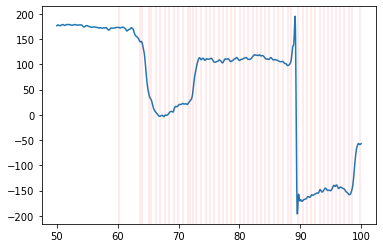

In [110]:
start_2 = 50
end_2 = 100
logit = (t>start_2) & (t<end_2)

plt.plot(t[logit],yaws_smooth[logit])
for i in step_tt:
    plt.axvline(i,c='r',alpha=0.1)

In [111]:
x = train_posi[(train_posi['trace']==trace) & (train_posi['trail']==trail)]['x'].loc[start:end].values
y = train_posi[(train_posi['trace']==trace) & (train_posi['trail']==trail)]['y'].loc[start:end].values

xx = [x[0]]
yy = [y[0]]
for sl,hd in zip(step_length,heading):
    xx.append(xx[-1]+sl*np.cos(hd/360*2*np.pi))
    yy.append(yy[-1]+sl*np.sin(hd/360*2*np.pi))

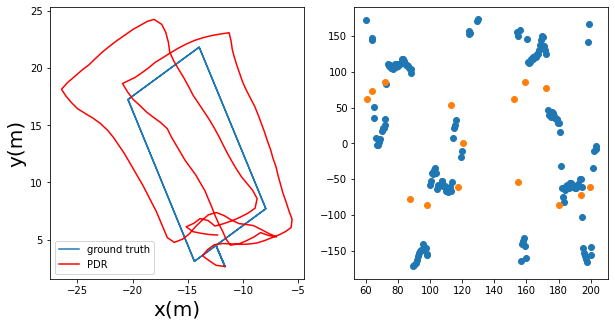

In [118]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x,y,label='ground truth')
plt.plot(xx,yy,c='r',label='PDR')
plt.xlabel('x(m)',fontsize=20)
plt.ylabel('y(m)',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
# estimated heading
plt.scatter(step_t,heading)

# reference heading
plt.scatter(train_posi[(train_posi['trace']==trace) & (train_posi['trail']==trail)].loc[start:end].iloc[:-1].index,np.arctan(y[1:]-y[:-1],x[1:]-x[:-1])/(2*np.pi)*360)

## pressure analysis--climbing stairs detection

In [30]:
pres = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]['Pres(mbar)'].loc[start:end].values

In [31]:
def dif(pres):
    difs = []
    for i,v in enumerate(pres):
        if i==0:
            difs.append(0)
        else:
            difs.append(pres[i]-pres[i-1])
    return np.array(difs)
#pres_dif = dif(smooth(pres,p=0.9))
#pres_dif = dif(lowpass(pres,cut_off=5))
pres_dif = smooth(dif(pres))


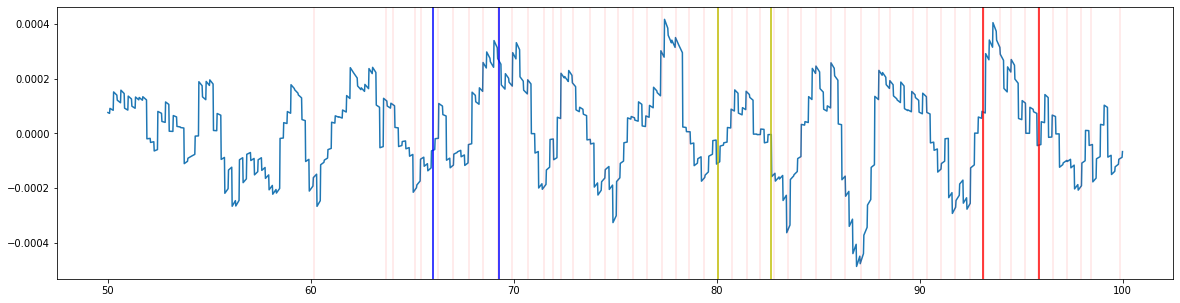

In [32]:
start_2 = 50
end_2 = 100
logit = (t>start_2) & (t<end_2)


plt.figure(figsize=(20,5))
plt.plot(t[logit],pres_dif[logit])

for i in step_t:
    if (i>start_2) & (i<end_2):
        plt.axvline(i,c='r',alpha=0.1)

plt.axvline(66.000,c='b')
plt.axvline(69.289,c='b')
plt.axvline(80.054,c='y')
plt.axvline(82.668,c='y')
plt.axvline(93.137,c='r')
plt.axvline(95.866,c='r')

# fusion

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
# random forest
rm_reg_x = RandomForestRegressor()
rm_reg_x.fit(train_feature,train_x)
rm_reg_y = RandomForestRegressor()
rm_reg_y.fit(train_feature,train_y)
rm_cls_f = RandomForestClassifier()
rm_cls_f.fit(train_feature,train_floor)

RandomForestClassifier()

In [34]:
# knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
knn_reg_x = KNeighborsRegressor()
knn_reg_x.fit(train_feature,train_x)
knn_reg_y = KNeighborsRegressor()
knn_reg_y.fit(train_feature,train_y)
knn_cls_f = KNeighborsClassifier()
knn_cls_f.fit(train_feature,train_floor)

KNeighborsClassifier()

In [35]:
# SVM
from sklearn.svm import SVC
from sklearn.svm import SVR
svm_reg_x = SVR()
svm_reg_x.fit(train_feature,train_x)
svm_reg_y = SVR()
svm_reg_y.fit(train_feature,train_y)
svm_cls_f = SVC()
svm_cls_f.fit(train_feature,train_floor)

SVC()

In [125]:
# wifi prediction tools
def wifi_adjust_time(wifi_df,wifi_frequency=0.25):
    '''
    align the time of the wifi dataframe
    '''
    _wifi_df = wifi_df.copy()
    raw_time = wifi_df.index
    pivot = raw_time[0]
    new_time = np.around((raw_time-pivot)/4)*(1/wifi_frequency) + pivot
    _wifi_df.index = new_time
    _wifi_df = _wifi_df[~_wifi_df.index.duplicated(keep='last')]
    return _wifi_df

def floor_corrected(floors):
    '''
    remove the abrupt change of floor to increase floor prediction accuracy
    '''
    floor_predicted = floors.copy()
    for index,val in enumerate(floor_predicted):
            if (index==0) or (index==len(floor_predicted-1)):
                continue
            window = floor_predicted[index-1:index+2]
            # calculate the frequency of val
            bincnt = np.bincount(window)
            mode = np.argmax(bincnt)
            # if frquency of mode>1, correct current val to mode
            if bincnt[mode]!=1:
                floor_predicted[index] = mode
    return floor_predicted

def wifi_feature(wifi_df):
    '''
    wifi_df should be the record of a single trace/trail
    '''
    time = wifi_df.index
    cols = list(wifi_df.columns)
    counter = 0
    if 'trace' in cols:
        counter+=1
        cols.remove('trace')
    if 'trail' in cols:
        counter+=1
        cols.remove('trail')
    wifi_fea = wifi_df[cols].values
    wifi_fea_df = pd.DataFrame(index=time,data=wifi_fea,columns=cols)
    return wifi_fea_df

def wifi_predict(wifi_fea_df,model_x,model_y,model_f,correct=True):
    '''
    res_df.index = time
    res_df.x
    res_df.y
    res_df.f
    '''
    time = wifi_fea_df.index
    fea = wifi_fea_df.values
    px = model_x.predict(fea)
    py = model_y.predict(fea)
    pf = model_f.predict(fea)
    if correct:
        pf = floor_corrected(pf)
    
    res_df = pd.DataFrame(index=time,data={'x':px,'y':py,'f':pf})
    return res_df
def pdr(sensors_df):
    '''
    res_df.index = step_time
    res_df.step_length
    res_df.heading
    '''
    yaws = sensors_df['YawZ(º)'].values
    yaws_smooth = smooth(yaws,p=0.7)    
    yaws_dif = dif_yaws(yaws)
    yaws_dif_var = var(yaws_dif)
    yaws_dif_var_smooth = smooth(yaws_dif_var,p=0.99)
    
    
    var_th = 0.4# threshold of the yaws variance, larger variance indicates calibrating or turning, not walking 
    dif_th = 2 # thereshold of dif
    spinning = (yaws_dif_var_smooth>var_th) | (smooth(yaws_dif,p=0.8)>dif_th)
    #spinning = yaws_dif_var_smooth>var_th
    
    acc_x = sensors_df['Acc_X(m/s^2)'].values
    acc_y = sensors_df['Acc_Y(m/s^2)'].values
    acc_z = sensors_df['Acc_Z(m/s^2)'].values
    acc_all = np.sqrt(acc_x**2+acc_y**2+acc_z**2)
    acc_all = lowpass(acc_all,cut_off=15)
    acc_zero = np.mean(acc_all[~spinning])
    acc_th = acc_zero + 0.7 # acc thereshold to detect peak
    t = sensors_df.index
    step_t = find_valid_peakT(t[~spinning],acc_all[~spinning],acc_th)
    
    acc_df = pd.DataFrame(index=sensors_df.index,data=acc_all)
    step_length = estimate_step_length(acc_df,step_t)
   
    yaws_lp = lowpass(-yaws,cut_off=7)        
    heading = estimate_heading(pd.DataFrame(index=t,data=yaws_lp),step_t)
    
    res_df = pd.DataFrame(index=step_t,data={'step_length':step_length,'heading':heading})
    res_df['heading_dif'] = (res_df['heading']-res_df['heading'].shift(1)).fillna(0).values
    return res_df

def pdr_predict(posi_df,sensors_df):
    pdr_df = pdr(sensors_df)
    xx = [posi_df['x'].values[0]]
    yy = [posi_df['y'].values[0]]
    for sl,hd in zip(pdr_df['step_length'],pdr_df['heading']):
        xx.append(xx[-1]+sl*np.cos(hd/360*2*np.pi))
        yy.append(yy[-1]+sl*np.sin(hd/360*2*np.pi))
    return pd.DataFrame(index=pdr_df.index,data={'x':xx[1:],'y':yy[1:]})
    
def pdr_augment(pdr_df,wifi_df):
    '''
    augment pdr_df with wifi_df
    '''
    res_df = pdr_df.copy()
    x = []
    y = []
    f = []
    for time in pdr_df.index:
        wifi_series = wifi_df.iloc[np.argmin(np.abs(wifi_df.index-time))]
        x.append(wifi_series['x'])
        y.append(wifi_series['y'])
        f.append(wifi_series['f'])
    res_df['x'] = x
    res_df['y'] = y
    res_df['f'] = f
    return res_df

def intergrate(pdr_df,wifi_df):
    '''
    maintain both full pdr_df and wifi_df
    '''
    df = pd.concat([pdr_df,wifi_df],axis=1)
    pdr_cols = list(pdr_df.columns)
    wifi_cols = list(wifi_df.columns)
    # find common columns
    common_cols = []
    for col in pdr_cols:
        if col in wifi_cols:
            common_cols.append(col)
    # rename columns
    wifi_cols = ['wifi_'+ col for col in wifi_cols]
    new_cols = pdr_cols.copy()
    new_cols.extend(wifi_cols)
    df.columns = new_cols
    # fill NaN values
    for col in pdr_cols:
        if (col=='step_length') or (col=='heading_dif'):
            df[col] = df[col].fillna(0)
        elif col=='heading':
            df[col] = df[col].fillna(method='bfill',axis=0).fillna(method='ffill',axis=0)
        if col in common_cols:
            df[col] = df[col].astype(np.float64).fillna(df['wifi_'+ col])
    df = df.drop(labels=wifi_cols,axis=1)
    return df
    

In [121]:
def score_2D(prediction_df,posi_df):
    pre_x = []
    pre_y = []
    for time in posi_df.index:
        tmp = prediction_df.iloc[np.argmin(np.abs(prediction_df.index-time))]
        pre_x.append(tmp['x'])
        pre_y.append(tmp['y'])
    # calculate x-y errors (in meter)
    errors = []
    for i,real_x,real_y in zip(range(len(pre_x)),posi_df['x'].values,posi_df['y'].values):
        error = np.sqrt((real_x-pre_x[i])**2+(real_y-pre_y[i])**2)
        errors.append(error)
    errors = pd.DataFrame(index=posi_df.index,data=errors,columns=['error(m)'])
    # statistical metrics
    print('mean errror(m):','%.2f'%np.mean(errors.values),)
    print('0.25 quantile errror(m):','%.2f'%np.quantile(errors.values,0.25,))
    print('0.75 quantile errror(m):','%.2f'%np.quantile(errors.values,0.75,))
    return errors

def score_3D(prediction_df,posi_df):
    pre_x = []
    pre_y = []
    pre_f = []
    for time in posi_df.index:
        tmp = prediction_df.iloc[np.argmin(np.abs(prediction_df.index-time))]
        pre_x.append(tmp['x'])
        pre_y.append(tmp['y'])
        pre_f.append(tmp['f'])
    # calculate x-y errors (in meter)
    errors = []
    floor_compare = []
    for i,real_x,real_y,real_f in zip(range(len(pre_x)),posi_df['x'].values,posi_df['y'].values,posi_df['floor ID'].values):
        error = np.sqrt((real_x-pre_x[i])**2+(real_y-pre_y[i])**2)
        errors.append(error)
        floor_compare.append([pre_f[i],real_f])
    errors = pd.DataFrame(index=posi_df.index,data=errors,columns=['error(m)'])
    floor_compare = pd.DataFrame(index=posi_df.index,data=np.array(floor_compare).reshape((-1,2)),columns=['prediction_floor','real_floor'])
    # statistical metrics
    print('mean errror(m):','%.2f'%np.mean(errors.values),)
    print('0.25 quantile errror(m):','%.2f'%np.quantile(errors.values,0.25,))
    print('0.75 quantile errror(m):','%.2f'%np.quantile(errors.values,0.75,))
    print('floor prediction accuracy:','%.2f'%(np.equal(floor_compare.iloc[:,0],floor_compare.iloc[:,1]).sum()/len(floor_compare)))
    return errors,floor_compare
def score_floor(prediction_df,posi_df):
    pre_f = []
    for time in posi_df.index:
        tmp = prediction_df.iloc[np.argmin(np.abs(prediction_df.index-time))]
        pre_f.append(tmp['f'])
    # calculate x-y errors (in meter)
    errors = []
    floor_compare = []  
    for i,real_f in zip(range(len(pre_f)),posi_df['floor ID'].values):
        floor_compare.append([pre_f[i],real_f])
    floor_compare = pd.DataFrame(index=posi_df.index,data=np.array(floor_compare).reshape((-1,2)),columns=['prediction_floor','real_floor'])
    print('floor prediction accuracy:','%.2f'%(np.equal(floor_compare.iloc[:,0],floor_compare.iloc[:,1]).sum()/len(floor_compare)))
        

In [126]:
# validation,random forest
valid_trace=1
_sensors_df = valid_sensors[(valid_sensors['trace']==valid_trace) ]
_wifi_df = valid_wifi[(valid_wifi['trace']==valid_trace) ]
_posi_df = valid_posi[(valid_posi['trace']==valid_trace) ]

# WIFI prediction
wifi_fea_df = wifi_feature(_wifi_df)
wifi_prediction_df = wifi_predict(wifi_fea_df,rm_reg_x,rm_reg_y,rm_cls_f)
wifi_prediction_df = wifi_adjust_time(wifi_prediction_df)
wifi_prediction_df_notcorrected = wifi_predict(wifi_fea_df,rm_reg_x,rm_reg_y,rm_cls_f,correct=False)
wifi_prediction_df_notcorrected = wifi_adjust_time(wifi_prediction_df)
#PDR prediction
pdr_prediction_df = pdr_predict(_posi_df,_sensors_df)
# UKF prediction
fusion_df = ukf_predict(_sensors_df,
               _wifi_df,
               _posi_df,
              knn_reg_x,knn_reg_y,knn_cls_f)

# EVALUATION
print('\nWifi Prediction score')
score_2D(wifi_prediction_df,_posi_df)
print('\nPDR Prediction score')
score_2D(pdr_prediction_df,_posi_df)
print('\nFusion Prediction score')
errors,floor_compare = score_3D(fusion_df,_posi_df)
score_floor(wifi_prediction_df_notcorrected,_posi_df)


Wifi Prediction score
mean errror(m): 2.89
0.25 quantile errror(m): 2.19
0.75 quantile errror(m): 3.28

PDR Prediction score
mean errror(m): 11.03
0.25 quantile errror(m): 9.18
0.75 quantile errror(m): 13.31

Fusion Prediction score
mean errror(m): 6.96
0.25 quantile errror(m): 5.40
0.75 quantile errror(m): 8.87
floor prediction accuracy: 1.00
floor prediction accuracy: 1.00


# UKF

In [184]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

def ukf_predict(sensors_df,wifi_df,posi_df,rm_reg_x,rm_reg_y,rm_cls_f):
    wifi_fea_df = wifi_feature(wifi_df)
    wifi_predict_df = wifi_predict(wifi_fea_df,rm_reg_x,rm_reg_y,rm_cls_f)
    wifi_predict_df = wifi_adjust_time(wifi_predict_df)

    # pdr: get step_time,step_length,heading
    pdr_df = pdr(sensors_df)
    # intergrate pdr res and wifi prediction res
    pdr_wifi = pdr_augment(pdr_df,wifi_predict_df)
    pdr_wifi = intergrate(pdr_wifi,wifi_predict_df)

    
    # UKF
    def transfer(x,dt):
        # state transfer matrix x,y,heading,step length
        F = np.array([x[0]+x[3]*np.cos(x[2]/360*2*np.pi),
                     x[1]+x[3]*np.sin(x[2]/360*2*np.pi),
                     x[2],
                     x[3]
                     ])
        return F.T
    def hx(x):
        return np.array(x)

    points = MerweScaledSigmaPoints(4,alpha=.1,beta=2,kappa=1.)
    ukf = UKF(dim_x=4,dim_z=4,fx=transfer,hx=hx,dt=1,points=points)
    ukf.x = np.array([posi_df.iloc[0]['x'],posi_df.iloc[0]['y'],0,0])
    # ukf.Q = np.diag([0.01,0.01,10/360*2*np.pi,0.01])
    # ukf.R = np.diag([1000,1000,10/360*2*np.pi,5])
    ukf.Q = np.diag([0.1,0.1,5/360*2*np.pi,1e-4])
    ukf.R = np.diag([10,10,5/360*2*np.pi,2])


    zs = np.concatenate([pdr_wifi['x'].values.reshape(-1,1),
                         pdr_wifi['y'].values.reshape(-1,1),
                         pdr_wifi['heading'].values.reshape(-1,1),
                         pdr_wifi['step_length'].values.reshape(-1,1)
                 ],axis=1)
    prediction_res = []
    for z in zs:
        ukf.predict()
        ukf.update(z)
        prediction_res.append(ukf.x.copy())
    prediction_res = np.array(prediction_res)
    # full prediction dataframe
    return pd.DataFrame(index=pdr_wifi.index,data={'x':prediction_res[:,0],'y':prediction_res[:,1],'f':pdr_wifi['f'].values})

In [39]:
# ## training,rm_x,rm_y,rm_f
# _sensors_df = train_sensors[(train_sensors['trace']==trace) & (train_sensors['trail']==trail)]
# _wifi_df = train_wifi[(train_wifi['trace']==trace) & (train_wifi['trail']==trail)]
# _posi_df = train_posi[(train_posi['trace']==trace) & (train_posi['trail']==trail)]

# # WIFI prediction
# wifi_fea_df = wifi_feature(_wifi_df)
# wifi_prediction_df = wifi_predict(wifi_fea_df,rm_reg_x,rm_reg_y,rm_cls_f)
# wifi_prediction_df = wifi_adjust_time(wifi_prediction_df)
# #PDR prediction
# pdr_prediction_df = pdr_predict(_posi_df,_sensors_df)
# # UKF prediction
# fusion_df = ukf_predict(_sensors_df,
#                _wifi_df,
#                _posi_df,
#                rm_reg_x,rm_reg_y,rm_cls_f)

# # EVALUATION
# print('\nWifi Prediction score')
# score_2D(wifi_prediction_df,_posi_df)
# print('\nPDR Prediction score')
# score_2D(pdr_prediction_df,_posi_df)
# print('\nFusion Prediction score')
# errors,floor_compare = score_3D(fusion_df,_posi_df)


Wifi Prediction score
mean errror(m): 3.05
0.25 quantile errror(m): 1.02
0.75 quantile errror(m): 4.02

PDR Prediction score
mean errror(m): 2.49
0.25 quantile errror(m): 1.32
0.75 quantile errror(m): 3.45

Fusion Prediction score
mean errror(m): 3.46
0.25 quantile errror(m): 1.87
0.75 quantile errror(m): 5.06
floor prediction accuracy: 1.00


# Validation

In [195]:
valid_trace=1


Wifi Prediction score
mean errror(m): 2.89
0.25 quantile errror(m): 2.19
0.75 quantile errror(m): 3.28

PDR Prediction score
mean errror(m): 11.03
0.25 quantile errror(m): 9.18
0.75 quantile errror(m): 13.31

Fusion Prediction score
mean errror(m): 2.35
0.25 quantile errror(m): 1.03
0.75 quantile errror(m): 3.52
floor prediction accuracy: 1.00
floor prediction accuracy: 1.00


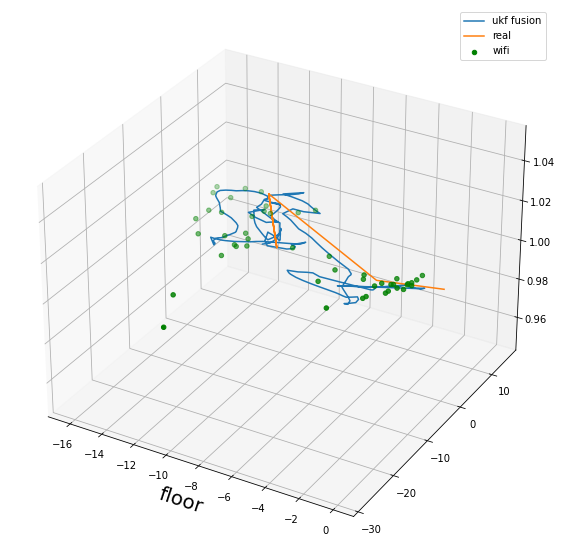

In [196]:
# validation,random forest
#valid_trace=5
_sensors_df = valid_sensors[(valid_sensors['trace']==valid_trace) ]
_wifi_df = valid_wifi[(valid_wifi['trace']==valid_trace) ]
_posi_df = valid_posi[(valid_posi['trace']==valid_trace) ]

# WIFI prediction
wifi_fea_df = wifi_feature(_wifi_df)
wifi_prediction_df = wifi_predict(wifi_fea_df,rm_reg_x,rm_reg_y,rm_cls_f)
wifi_prediction_df = wifi_adjust_time(wifi_prediction_df)
wifi_prediction_df_notcorrected = wifi_predict(wifi_fea_df,rm_reg_x,rm_reg_y,rm_cls_f,correct=False)
wifi_prediction_df_notcorrected = wifi_adjust_time(wifi_prediction_df)
#PDR prediction
pdr_prediction_df = pdr_predict(_posi_df,_sensors_df)
# UKF prediction
fusion_df = ukf_predict(_sensors_df,
               _wifi_df,
               _posi_df,
               rm_reg_x,rm_reg_y,rm_cls_f)

# EVALUATION
print('\nWifi Prediction score')
score_2D(wifi_prediction_df,_posi_df)
print('\nPDR Prediction score')
score_2D(pdr_prediction_df,_posi_df)
print('\nFusion Prediction score')
errors,floor_compare = score_3D(fusion_df,_posi_df)
score_floor(wifi_prediction_df_notcorrected,_posi_df)

plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot3D(fusion_df['x'].values,fusion_df['y'].values,fusion_df['f'].values,label='ukf fusion')
#ax.plot3D(pdr_prediction_df['x'].values,pdr_prediction_df['y'].values,pdr_prediction_df['f'].values,label='pdr')
ax.plot3D(_posi_df['x'].values,_posi_df['y'].values,_posi_df['floor ID'].values,label='real')
ax.scatter3D(wifi_prediction_df['x'].values,wifi_prediction_df['y'].values,wifi_prediction_df['f'].values,label='wifi',c='g')
ax.set_xlabel('x',fontsize=20)
ax.set_xlabel('y',fontsize=20)
ax.set_xlabel('floor',fontsize=20)
plt.legend()


Wifi Prediction score
mean errror(m): 1.01
0.25 quantile errror(m): 0.33
0.75 quantile errror(m): 1.61

PDR Prediction score
mean errror(m): 11.03
0.25 quantile errror(m): 9.18
0.75 quantile errror(m): 13.31

Fusion Prediction score
mean errror(m): 1.55
0.25 quantile errror(m): 0.93
0.75 quantile errror(m): 2.30
floor prediction accuracy: 1.00
floor prediction accuracy: 1.00


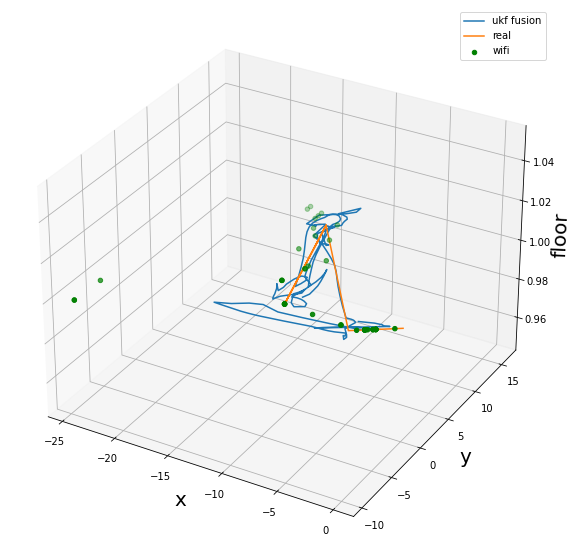

In [199]:
# validation,knn_x,knn_y,knn_f
#valid_trace=1
_sensors_df = valid_sensors[(valid_sensors['trace']==valid_trace) ]
_wifi_df = valid_wifi[(valid_wifi['trace']==valid_trace) ]
_posi_df = valid_posi[(valid_posi['trace']==valid_trace) ]

# WIFI prediction
wifi_fea_df = wifi_feature(_wifi_df)
wifi_prediction_df = wifi_predict(wifi_fea_df,knn_reg_x,knn_reg_y,knn_cls_f)
wifi_prediction_df = wifi_adjust_time(wifi_prediction_df)
wifi_prediction_df_notcorrected = wifi_predict(wifi_fea_df,knn_reg_x,knn_reg_y,knn_cls_f,correct=False)
wifi_prediction_df_notcorrected = wifi_adjust_time(wifi_prediction_df)
#PDR prediction
pdr_prediction_df = pdr_predict(_posi_df,_sensors_df)
# UKF prediction
fusion_df = ukf_predict(_sensors_df,
               _wifi_df,
               _posi_df,
               knn_reg_x,knn_reg_y,knn_cls_f)

# EVALUATION
print('\nWifi Prediction score')
score_2D(wifi_prediction_df,_posi_df)
print('\nPDR Prediction score')
score_2D(pdr_prediction_df,_posi_df)
print('\nFusion Prediction score')
errors,floor_compare = score_3D(fusion_df,_posi_df)

score_floor(wifi_prediction_df_notcorrected,_posi_df)

plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot3D(fusion_df['x'].values,fusion_df['y'].values,fusion_df['f'].values,label='ukf fusion')
#ax.plot3D(pdr_prediction_df['x'].values,pdr_prediction_df['y'].values,pdr_prediction_df['f'].values,label='pdr')
ax.plot3D(_posi_df['x'].values,_posi_df['y'].values,_posi_df['floor ID'].values,label='real')
ax.scatter3D(wifi_prediction_df['x'].values,wifi_prediction_df['y'].values,wifi_prediction_df['f'].values,label='wifi',c='g')
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.set_zlabel('floor',fontsize=20)
plt.legend()

In [198]:
# validation,svm_x,svm_y,svm_f
#valid_trace=1
_sensors_df = valid_sensors[(valid_sensors['trace']==valid_trace) ]
_wifi_df = valid_wifi[(valid_wifi['trace']==valid_trace) ]
_posi_df = valid_posi[(valid_posi['trace']==valid_trace) ]

# WIFI prediction
wifi_fea_df = wifi_feature(_wifi_df)
wifi_prediction_df = wifi_predict(wifi_fea_df,svm_reg_x,svm_reg_y,svm_cls_f)
wifi_prediction_df = wifi_adjust_time(wifi_prediction_df)
wifi_prediction_df_notcorrected = wifi_predict(wifi_fea_df,svm_reg_x,svm_reg_y,svm_cls_f,correct=False)
wifi_prediction_df_notcorrected = wifi_adjust_time(wifi_prediction_df)
#PDR prediction
pdr_prediction_df = pdr_predict(_posi_df,_sensors_df)
# UKF prediction
fusion_df = ukf_predict(_sensors_df,
               _wifi_df,
               _posi_df,
               svm_reg_x,svm_reg_y,svm_cls_f)
# EVALUATION
print('\nWifi Prediction score')
score_2D(wifi_prediction_df,_posi_df)
print('\nPDR Prediction score')
score_2D(pdr_prediction_df,_posi_df)
print('\nFusion Prediction score')
errors,floor_compare = score_3D(fusion_df,_posi_df)

score_floor(wifi_prediction_df_notcorrected,_posi_df)


Wifi Prediction score
mean errror(m): 7.09
0.25 quantile errror(m): 4.45
0.75 quantile errror(m): 8.68

PDR Prediction score
mean errror(m): 11.03
0.25 quantile errror(m): 9.18
0.75 quantile errror(m): 13.31

Fusion Prediction score
mean errror(m): 6.54
0.25 quantile errror(m): 4.12
0.75 quantile errror(m): 8.88
floor prediction accuracy: 1.00
floor prediction accuracy: 1.00
